In [161]:
import skimage.transform

import numpy as np
from matplotlib import pyplot as plt
from math import exp

plt.set_cmap('terrain');

<Figure size 432x288 with 0 Axes>

In [162]:
class terrain(object):
    def __init__(self,seed=42):
        '''self.img is the main terrain'''
        self.img = np.zeros((2,3),dtype=np.float)
        self.rand = np.random.RandomState(seed=seed)
        
    def genV1(self,imax=15,smallness=0.75,scale=1.5,maxsize=10**7):
        '''generates map that with large features first then smaller features
        This is done by adding normal noise and enlarging the array'''
        
        outsize = self.img.shape[0]*self.img.shape[1]*scale**(2*(imax-1))
        assert maxsize>outsize, 'Potential Memory error: Size = 6*scale**(2*(imax-1)) = {} is above maxsize = {}'.format(outsize,maxsize)
        
        J = smallness
        for i in range(imax):
            self.img += self.rand.normal(scale=J**i,size=self.img.shape) #add noise with amplitude J**i (J<1 thus smaller for large i)
            if i==imax-1:
                break
            self.img = skimage.transform.rescale(self.img,scale,anti_aliasing=False,mode='reflect',multichannel=False)
    
    def addseasnow(self,img,seafrac=0.5,snowfrac=0.05):
        '''adds snow and sea by clipping the self.img terrain array
        This work because the color map terrain: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        has blue at the lowest value and white at the highest value'''
        pmin = np.percentile(img,seafrac*100)
        pmax = np.percentile(img,(1-snowfrac)*100)
        img = np.clip(img,pmin,pmax) #make snow and sea
        return img
    
    def addbeach(self,img,vmin=0.15,vmax=0.25):
        '''adds beach
        This work because the color map terrain: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
        has sand colour at the middle value'''
        Amin,Amax = np.min(img),np.max(img)
        img2 = (img-Amin)/(Amax-Amin) #rescale 0<=img2<=1
        img[(img2>vmin)*(img2<vmax)] = (Amax+Amin)/2 #set shoreline
        return img
    
    def plot(self,raw=False):
        '''simple plotter, uses terrain colour map: https://matplotlib.org/users/colormaps.html'''
        img = np.copy(self.img)
        if not raw:
            img = self.addseasnow(img)
            img = self.addbeach(img)
        plt.figure(figsize=(15,12))
        plt.imshow(img,cmap='terrain')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    


$$ \Delta t = \frac{L}{|v| + \epsilon}$$
$$x' = x + v \Delta t$$
$$v' = (-g \nabla h(x) - \gamma v) \Delta t + v$$
$$c' =\frac{e^{-\frac{\text{$\Delta $t}}{\tau }} \left(\text{c0} \text{$\Delta $t}+c_m'
   \left(e^{\text{$\Delta $t}/\tau } (\text{$\Delta $t}-\tau )+\tau \right)-c_m
   \left(-\tau  e^{\text{$\Delta $t}/\tau }+\text{$\Delta $t}+\tau
   \right)\right)}{\text{$\Delta $t}}$$


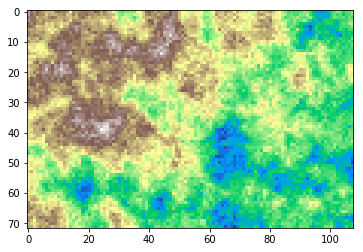

In [63]:
ter = terrain()
ter.genV1(imax=10)
plt.imshow(ter.img)
plt.show()

In [176]:

L = 1/2
dtmax = 10
gamma = 0.05
cmax = lambda v: np.sum(v**2)**0.5
tau = 1
g = 1
cpickup = 0.01
if True:
    xgrid,ygrid = np.arange(50),np.arange(50)
    Xgrid,Ygrid = np.meshgrid(xgrid,ygrid)
    h = np.array((Xgrid-25)**2+(Ygrid-25)**2,dtype=float)
else:
    h = ter.img
h = np.copy(h)
h -= np.mean(h)
h /= np.std(h)*(2*g)
h0 = np.copy(h)
x = np.array([0,0])
v = np.array([1,0])
c = 0

xhist = [x]
thist = [0]
vhist = [v]
chist = [c]

DX = DY = 1
eps = 0.5
for i in range(1000):
    xm,xp = int(x[0])%h.shape[1],(int(x[0])+1)%h.shape[1]
    ym,yp = int(x[1])%h.shape[0],(int(x[1])+1)%h.shape[0]
    gx = ((h[ym,xp]-h[ym,xm])/DX + (h[yp,xp]-h[yp,xm])/DX)/2
    gy = ((h[yp,xm]-h[ym,xm])/DY + (h[yp,xp]-h[ym,xp])/DY)/2
#     print(xm,xp,ym,yp,gx,gy)
    a = (-g*np.array([gx,gy])-gamma*v)
    
    vabs,aabs = np.sum(v**2)**0.5,np.sum(a**2)**0.5
    dtvel = (-vabs + (vabs**2+2*aabs*L)**0.5)/aabs if aabs>1e-20 else L/vabs
    dtdrag = 1/gamma
    dt = min(dtvel,dtdrag,dtmax)
#     dt = 0.001
    xnew = x + v*dt
    vnew = v + a*dt

    cnew = exp(-dt/tau)/dt*(c*dt+
         cmax(np.sum(vnew**2)**0.5)*(exp(dt/tau)*(dt-tau)+tau)-
         cmax(np.sum(v**2)**0.5)*(-tau*exp(dt/tau)+dt+tau))
    dc = cnew-c #if positive than pickup other drop
    
    x,v,c = xnew,vnew,cnew
#     print('x',x,'v',v,'dt',dt)
    xhist.append(x)
    vhist.append(v)
    thist.append(thist[-1]+dt)
    chist.append(c)
    h[ym,xm] -= dc*cpickup/4
    h[ym,xp] -= dc*cpickup/4
    h[yp,xm] -= dc*cpickup/4
    h[yp,xp] -= dc*cpickup/4
    # cmaxold = cmax(v)
    # cmaxnew = cmax(vprime)
    # cprime = 
xhist = np.array(xhist)
thist = np.array(thist)
vhist = np.array(vhist)
chist = np.array(chist)

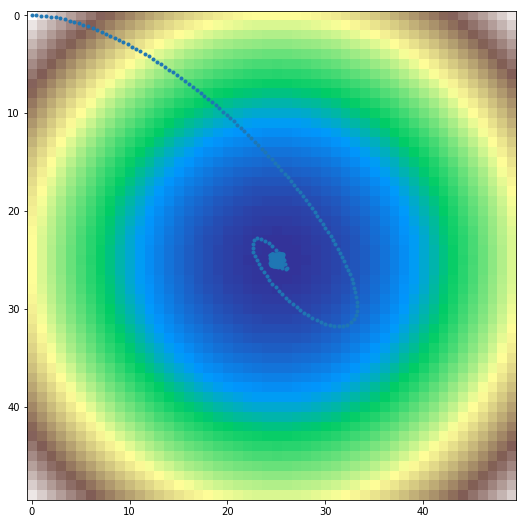

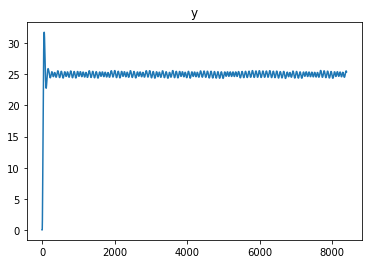

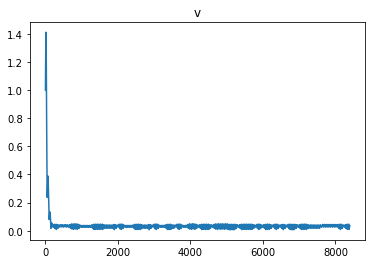

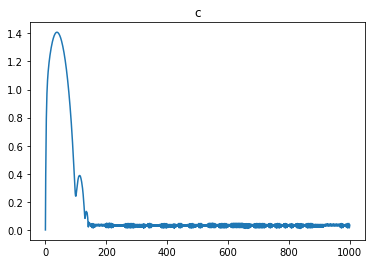

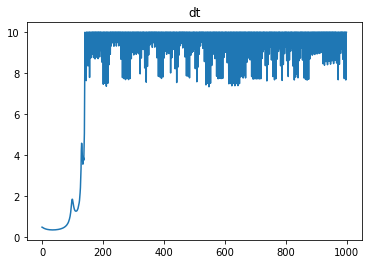

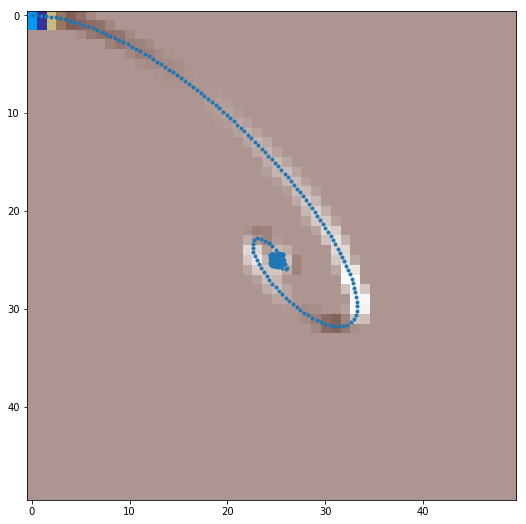

In [177]:
plt.figure(figsize=(16,9))
plt.imshow(h)
xhist = np.array(xhist)
plt.plot(xhist[:,0]%h.shape[1],xhist[:,1]%h.shape[0],'.')
plt.show()



plt.title('y')
plt.plot(thist,xhist[:,1])
plt.show()
plt.title('v')
plt.plot(thist,np.sum(vhist**2,axis=1)**0.5)
plt.show()
plt.title('c')
plt.plot(chist)
plt.show()
plt.title('dt')
plt.plot(thist[1:]-thist[:-1])
plt.show()
plt.figure(figsize=(16,9))
plt.imshow(h-h0)
xhist = np.array(xhist)
plt.plot(xhist[:,0]%h.shape[1],xhist[:,1]%h.shape[0],'.')
plt.show()

In [183]:
abs(h-h0)

array([[0.00198252, 0.00242901, 0.00068291, ..., 0.        , 0.        ,
        0.        ],
       [0.00198252, 0.00242901, 0.00068291, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [184]:
h0

array([[1.5773562 , 1.48457054, 1.39557205, ..., 1.31036073, 1.39557205,
        1.48457054],
       [1.48457054, 1.39178488, 1.30278639, ..., 1.21757507, 1.30278639,
        1.39178488],
       [1.39557205, 1.30278639, 1.2137879 , ..., 1.12857658, 1.2137879 ,
        1.30278639],
       ...,
       [1.31036073, 1.21757507, 1.12857658, ..., 1.04336526, 1.12857658,
        1.21757507],
       [1.39557205, 1.30278639, 1.2137879 , ..., 1.12857658, 1.2137879 ,
        1.30278639],
       [1.48457054, 1.39178488, 1.30278639, ..., 1.21757507, 1.30278639,
        1.39178488]])

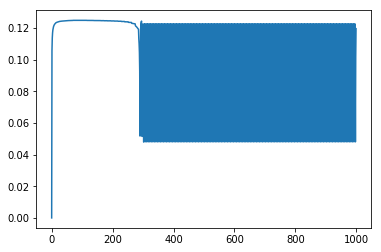

In [148]:
plt.plot(np.sum((xhist[:-1,:]-xhist[1:,:])**2,axis=1)**0.5 )